<a href="https://colab.research.google.com/github/PragyaKumari2203/Image-Captioning-Model/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-requisites

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Image-Captioning-Model

/content/drive/MyDrive/Image-Captioning-Model


In [ ]:
# Install dependencies
!pip install -r requirements.txt

# **Data Preparation**




In [59]:
PATH_TO_CAPTIONS = "./Flickr8k_text/Flickr8k.token.txt"
PATH_TO_IMAGES = "./Flickr8k_Dataset"
PATH_TO_TRAINING_DATA = "./Flickr8k_text/Flickr_8k.trainImages.txt"
PATH_TO_VALIDATION_DATA = "./Flickr8k_text/Flickr_8k.devImages.txt"
PATH_TO_TEST_DATA = "./Flickr8k_text/Flickr_8k.testImages.txt"

## Loading image-caption pairs

In [102]:
import os
import torch
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image

In [103]:
def load_captions(filename):
  captions = {}
  with open(filename, 'r', encoding='utf-8') as f:
    for line in f:
      parts = line.strip().split('\t')
      if len(parts) < 2:
        continue
      jpg_filename, caption = parts[0] .split('#')[0], parts[1]
      if jpg_filename not in captions:
        captions[jpg_filename] = []
      captions[jpg_filename].append(caption)
  return captions

## Image and text preprocessing

In [104]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(caption,max_length = 30):
  tokens = tokenizer(
      caption,
      max_length = max_length,
      padding = "max_length",
      truncation = True,
      return_tensors = "pt"
  )
  return tokens.input_ids.squeeze(0), tokens.attention_mask.squeeze(0)

## Writing Custom Dataset

In [105]:
class Flickr8kDataset(Dataset):
  def __init__(self,image_dir,captions_dict,image_filenames,tokenizer=None,transform=None,max_length=30):
    """
        Args:
            image_dir (str): Path to the directory containing images.
            captions_dict (dict): Dictionary mapping image filenames to a list of captions.
            image_filenames (list): List of image filenames for this dataset split (train/val/test).
            tokenizer: Hugging Face tokenizer for captions.
            transform: Image transformations.
            max_length (int): Maximum token length for captions, default = 30.
    """
    self.image_dir = image_dir
    self.captions_dict = captions_dict
    self.image_filenames = image_filenames
    self.tokenizer = tokenizer
    self.transform = transform
    self.max_length = max_length

  def __len__(self):
    return len(self.image_filenames)

  def __getitem__(self,idx):
    image_filename = self.image_filenames[idx]
    image_path = os.path.join(self.image_dir,image_filename)
    image = Image.open(image_path)

    if self.transform:
      image = self.transform(image)

    captions = self.captions_dict[image_filename]
    caption_sel = captions[torch.randint(0,len(captions),(1,)).item()]
    input_ids, attention_mask = self.tokenizer(caption_sel, self.max_length)

    return image, input_ids, attention_mask

In [106]:
def image_list(filepath):
  with open(filepath,'r') as f:
    return [line.strip() for line in f.readlines()]

training_data = image_list(PATH_TO_TRAINING_DATA)
validation_data = image_list(PATH_TO_VALIDATION_DATA)
test_data = image_list(PATH_TO_TEST_DATA)

print(f"Number of training images: {len(training_data)}")
print(f"Number of validation images: {len(validation_data)}")
print(f"Number of test images: {len(test_data)}")

Number of training images: 6000
Number of validation images: 1000
Number of test images: 1000


In [107]:
captions = load_captions(PATH_TO_CAPTIONS)

example_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = training_data,
    tokenizer = tokenize,
    max_length = 30
)

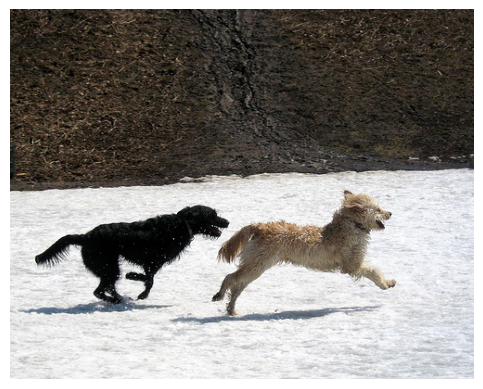

Tokenized IDs: tensor([ 101, 1037, 2304, 3899, 2003, 2770, 2044, 1037, 2317, 3899, 1999, 1996,
        4586, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])
Input IDs to text: [CLS] a black dog is running after a white dog in the snow. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Input IDs to tokens: ['[CLS]', 'a', 'black', 'dog', 'is', 'running', 'after', 'a', 'white', 'dog', 'in', 'the', 'snow', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [108]:
fig = plt.figure()
image, input_ids, attention_mask = example_dataset[0]
plt.imshow(image)
plt.axis('off')
plt.show()

print(f"Tokenized IDs: {input_ids}")
print(f"Input IDs to text: {tokenizer.decode(input_ids)}")
print(f"Input IDs to tokens: {tokenizer.convert_ids_to_tokens(input_ids)}")

## Creating dataloaders

In [109]:
training_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = training_data,
    tokenizer = tokenize,
    max_length = 30
)

valid_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = validation_data,
    tokenizer = tokenize,
    max_length = 30
)

test_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = test_data,
    tokenizer = tokenize,
    max_length = 30
)

In [110]:
train_dataloader = DataLoader(training_dataset,batch_size = 32,shuffle = True, num_workers = 2)
valid_dataloader = DataLoader(valid_dataset,batch_size = 32,shuffle = False,num_workers = 2)
test_dataloader = DataLoader(test_dataset,batch_size = 32,shuffle = False,num_workers = 2)